<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_LR/Covid19FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Kaggle dataset download
path = kagglehub.dataset_download("invalizare/covid-19-fake-news-dataset")
dataset_dir = "/root/.cache/kagglehub/datasets/invalizare/covid-19-fake-news-dataset/"

# Dynamically locate the Val.csv file
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Val.csv" in file:
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

# Display dataset preview and statistics
print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Check and handle missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'label'], inplace=True)

# Rename columns for consistency
df.rename(columns={'tweet': 'text', 'label': 'label'}, inplace=True)

# Filter the data to include only texts with length < 50 and remove duplicates
filtered_texts = []
filtered_labels = []
for text, label in zip(df['text'], df['label']):
    if len(text) > 50 and text not in filtered_texts:
        filtered_texts.append(text)
        filtered_labels.append(label)

# Create a new filtered DataFrame
filtered_df = pd.DataFrame({'text': filtered_texts, 'label': filtered_labels})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset preview:
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real

Dataset statistics:
                id
count  2140.000000
mean   1070.500000
std     617.909109
min       1.000000
25%     535.750000
50%    1070.500000
75%    1605.250000
max    2140.000000

Missing values per column:
id       0
tweet    0
label    0
dtype: int64


In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text preprocessing
filtered_df['processed_text'] = filtered_df['text'].apply(preprocess_text)

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['processed_text'], filtered_df['label'], test_size=0.2, random_state=42
)


Model Accuracy: 0.89
Unique classes in test labels: ['fake', 'real']

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.85      0.87       188
        True       0.88      0.91      0.90       232

    accuracy                           0.89       420
   macro avg       0.89      0.88      0.88       420
weighted avg       0.89      0.89      0.89       420



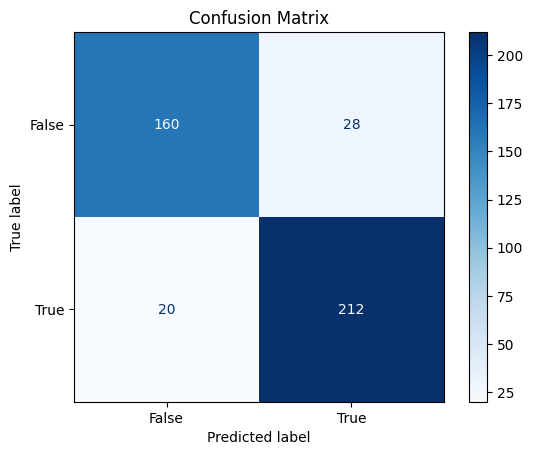


Sample Predictions:

Sample 1
Text: the covid19nigeria situation report for 13th may 2020 has been published yesterday the number of discharged cases in nigeria crossed the 1000 mark our daily covid19 situation report provides more details on this amp nigerias response download via httpstcoxo1wg4qdyt httpstcoiii0egbgzb
Predicted: True, Actual: True

Sample 2
Text: rt cdcdirector in every crisis there is an opportunity the covid19 pandemic is highlighting the need for us as a nation to address l
Predicted: True, Actual: True

Sample 3
Text: a video shows healthcare workers celebrating in a hospital the caption says it was filmed in messejana hospital in fortaleza brazil after all covid19 patients were cured and a whole hospital wing was closed
Predicted: True, Actual: True

Sample 4
Text: govt of nigeria is restricting entry into the country for travellers from china italy iran south korea spain japan france germany united states of america norway united kingdom netherlands amp switzer

In [ ]:
# Tfidf
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Model Training with Logistic Regression
model = LogisticRegression(max_iter=200, solver='saga', penalty='l2', C=1.0)
model.fit(X_train, train_labels)

# Predict on the test set
predictions = model.predict(X_test)

accuracy = accuracy_score(test_labels, predictions)
print(f"\nModel Accuracy: {accuracy:.2f}")

# Handle single-class cases for classification report and confusion matrix
unique_classes = sorted(test_labels.unique())
print("Unique classes in test labels:", unique_classes)

# Adjust target names dynamically based on unique classes
target_names = ['False', 'True'][:len(unique_classes)]

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, predictions, labels=unique_classes, target_names=target_names))

# Confusion Matrix
if len(unique_classes) > 1:  # Plot confusion matrix only if there are at least two classes
    conf_matrix = confusion_matrix(test_labels, predictions)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("\nConfusion Matrix not displayed due to single class in the test set.")

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], predictions[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")